## PyTorch practice, hints and Dataloaders

Credits:
* First part is based on YSDA [Practical RL course week04 materials](https://github.com/yandexdataschool/Practical_RL/tree/master/week04_%5Brecap%5D_deep_learning).
* Second part is based on PyTorch official tutorials and [this kaggle kernel](https://www.kaggle.com/pinocookie/pytorch-dataset-and-dataloader)
* Third part is based on PyTorch tutorial by [Stanford CS 231n course](http://cs231n.stanford.edu)

![img](https://pytorch.org/tutorials/_static/pytorch-logo-dark.svg)

__This notebook__ will remind you how to use pytorch low and high-level core. You can install it [here](http://pytorch.org/).

__Pytorch feels__ differently than other frameworks (like tensorflow/theano) on almost every level. TensorFlow makes your code live in two "worlds" simultaneously:  symbolic graphs and actual tensors. First you declare a symbolic "recipe" of how to get from inputs to outputs, then feed it with actual minibatches of data.  In pytorch, __there's only one world__: all tensors have a numeric value.

You compute outputs on the fly without pre-declaring anything. The code looks exactly as in pure numpy with one exception: pytorch computes gradients for you. And can run stuff on GPU. And has a number of pre-implemented building blocks for your neural nets. [And a few more things.](https://medium.com/towards-data-science/pytorch-vs-tensorflow-spotting-the-difference-25c75777377b)

Let's dive into it!

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
from torchvision import transforms

### Task 1: Tensormancy

__1.1 The [_disclaimer_](https://gist.githubusercontent.com/justheuristic/e2c1fa28ca02670cabc42cacf3902796/raw/fd3d935cef63a01b85ed2790b5c11c370245cbd7/stddisclaimer.h)__

Let's write another function, this time in polar coordinates:
$$\rho(\theta) = (1 + 0.9 \cdot cos (6 \cdot \theta) ) \cdot (1 + 0.01 \cdot cos(24 \cdot \theta)) \cdot (0.5 + 0.05 \cdot cos(200 \cdot \theta)) \cdot (10 + sin(10 \cdot \theta))$$


Then convert it into cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)) and plot the results.

Use torch tensors only: no lists, loops, numpy arrays, etc.

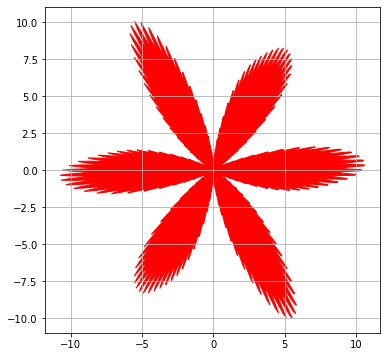

In [8]:
theta = torch.linspace(-np.pi, np.pi, steps=1000)

# compute rho(theta) as per formula above
rho = (1 + 0.9 * torch.cos(6 * theta)) * (1 + 0.01 * torch.cos(24 * theta)) * (0.5 + 0.05 * torch.cos(200 * theta)) * (10 + torch.sin(10 * theta))### YOUR CODE HERE

# Now convert polar (rho, theta) pairs into cartesian (x,y) to plot them.
x = rho * torch.cos(theta) ### YOUR CODE HERE
y = rho * torch.sin(theta) ### YOUR CODE HERE


plt.figure(figsize=(6, 6))
plt.fill(x.numpy(), y.numpy(), color='red')
plt.grid()

### Task 2: Using the Dataloader

In [2]:
from torch import nn
from torch.nn import functional as F

In [3]:
# !wget https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/week01_General_recap_and_vanishng_gradients/notmnist.py -ncc

In [4]:
from notmnist import load_notmnist
X_train, y_train, X_test, y_test = load_notmnist()

Extracting ...
Parsing...
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


In [9]:
X_train.shape

(14043, 1, 28, 28)

In [20]:
class DatasetMNIST(Dataset):
    def __init__(self, path='./notMNIST_small', letters='ABCDEFGHIJ', transform=None):
        self.data, self.labels, _ ,_  = load_notmnist(path=path, letters=letters, test_size=0)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, i don't use ToTensor() method of torchvision.transforms
        # so you can convert numpy ndarray shape to tensor in PyTorch (H, W, C) --> (C, H, W)
        image = self.data[index].transpose(1, 2, 0)
        label = self.labels[index]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [31]:
full_dataset = DatasetMNIST('./notMNIST_small', 'AB', transform=None)#torchvision.transforms.ToTensor())

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


In [32]:
# we can access and get data with index by __getitem__(index)
img, lab = full_dataset.__getitem__(0)

print(img.shape)
print(type(img))

(28, 28, 1)
<class 'numpy.ndarray'>


In [30]:
img.shape

torch.Size([1, 28, 28])

In [24]:
np.allclose(img, full_dataset[0][0])

True

In [25]:
a = torchvision.transforms.ToTensor()

a(img).shape

torch.Size([1, 28, 28])

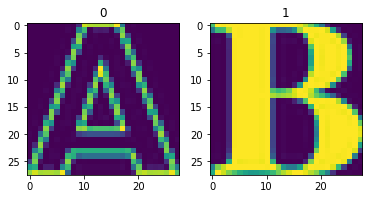

In [26]:
inds = np.random.randint(len(full_dataset), size=2)

for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(full_dataset[inds[i]][0].reshape([28,28]))
    plt.title(str(full_dataset[inds[i]][1]))

#### To the DataLoader

In [33]:
train_loader = DataLoader(full_dataset, batch_size=8, shuffle=True)

We can use dataloader as iterator by using iter() function.

In [34]:
train_iter = iter(train_loader)
print(type(train_iter))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>


We can look at images and labels of batch size by extracting data `.next()` method.

In [36]:
images, labels = train_iter.next()

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

images shape on batch size = torch.Size([8, 28, 28, 1])
labels shape on batch size = torch.Size([8])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/rads/miniconda3/envs/py3_research/lib/python3.8/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


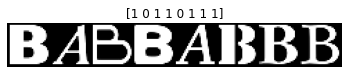

In [37]:
# make grid takes tensor as arg
# tensor : (batchsize, channels, height, width)
grid = torchvision.utils.make_grid(images.permute([0, 3, 1, 2]))

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title(labels.numpy());

And now with transformations:

In [38]:
train_dataset_with_transform = DatasetMNIST(
    transform=torchvision.transforms.ToTensor()
)

Parsing...
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


In [41]:
img, lab = train_dataset_with_transform[0]

print('image shape at the first row : {}'.format(img.size()))

image shape at the first row : torch.Size([1, 28, 28])


In [42]:
train_loader_tr = DataLoader(train_dataset_with_transform, batch_size=8, shuffle=True)

train_iter_tr = iter(train_loader_tr)
print(type(train_iter_tr))

images, labels = train_iter_tr.next()

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
images shape on batch size = torch.Size([8, 1, 28, 28])
labels shape on batch size = torch.Size([8])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


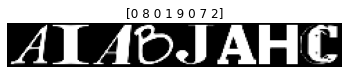

In [43]:
grid = torchvision.utils.make_grid(images)

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title(labels.numpy());

### Composing several transformations

If you want to take data augmentation, you have to make List using `torchvision.transforms.Compose`

```
class Compose(object):
    """Composes several transforms together.
    Args:
        transforms (list of ``Transform`` objects): list of transforms to compose.
    Example:
        >>> transforms.Compose([
        >>>     transforms.CenterCrop(10),
        >>>     transforms.ToTensor(),
        >>> ])
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        for t in self.transforms:
            format_string += '\n'
            format_string += '    {0}'.format(t)
        format_string += '\n)'
        return format_string
```


this function can convert some image by order within `__call__` method.

In [44]:
class Flatten():
    def __call__(self, pic):
        return pic.flatten()

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [45]:
a = Flatten()

In [46]:
a(img).shape

torch.Size([784])

In [47]:
new_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    Flatten()
])

In [48]:
new_dataset = DatasetMNIST(
    transform=new_transform
)

Parsing...
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


In [51]:
new_dataset[0][0].shape

torch.Size([784])

# Putting all together

In [52]:
import time

from IPython.display import clear_output

In [53]:
# use GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [55]:
device

device(type='cuda')

In [56]:
def subset_ind(dataset, ratio: float):
#     return ### YOUR CODE HERE
    return np.random.choice(len(dataset), size=int(ratio*len(dataset)), replace=False)

In [57]:
dataset = DatasetMNIST(
    './notMNIST_small',
#     'AB',
    transform=new_transform
)

shrink_inds = subset_ind(dataset, 0.2)
dataset = Subset(dataset, shrink_inds)

print(f'\n\n dataset size: {len(dataset)}, labels: {np.unique(dataset.dataset.labels)}')

Parsing...
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


 dataset size: 3744, labels: [0 1 2 3 4 5 6 7 8 9]


In [59]:
val_size = 0.2
val_inds = subset_ind(dataset, val_size)

train_dataset = Subset(dataset, [i for i in range(len(dataset)) if i not in val_inds])
val_dataset = Subset(dataset, val_inds)

print(f'  training size: {len(train_dataset)}\nvalidation size: {len(val_dataset)}')

  training size: 2996
validation size: 748


In [60]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [61]:
train_iter = iter(train_loader)
print(type(train_iter))

images, labels = train_iter.next()

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
images shape on batch size = torch.Size([32, 784])
labels shape on batch size = torch.Size([32])


In [77]:
loss_func = nn.CrossEntropyLoss()

In [ ]:
p * log(q)

In [ ]:
nn.CrossEntropyLoss

nn.NLLLoss

In [101]:
# create network again just in case
model = nn.Sequential(
    nn.Linear(784, 10),
#     nn.Sigmoid(),
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [102]:
next(iter(model.parameters())).device

device(type='cuda', index=0)

In [103]:
a = torch.ones(1)
b = torch.zeros(3)

In [104]:
a.device

device(type='cpu')

In [105]:
device

device(type='cuda')

In [106]:
a = a.to(device)
b.to(device)

tensor([0., 0., 0.], device='cuda:0')

In [107]:
print(a.device, b.device)

cuda:0 cpu


In [108]:
example_output = model(images.to(device))

In [109]:
loss = loss_func(example_output, labels.to(device))

In [110]:
loss.backward()

In [111]:
pred_labels = torch.argmax(example_output, dim=-1)

In [112]:
accuracy_score = np.mean(pred_labels.cpu().numpy() == labels.numpy())

In [113]:
accuracy_score

0.15625

In [114]:
import this

In [115]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
    '''
    model: нейросеть для обучения,
    train_loader, val_loader: загрузчики данных
    loss_fn: целевая метрика (которую будем оптимизировать)
    opt: оптимизатор (обновляет веса нейросети)
    n_epochs: кол-во эпох, полных проходов датасета
    '''
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            opt.zero_grad()
            
            # move data to target device
            ### YOUR CODE HERE
            
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            y_pred = model(X_batch)
            
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            opt.step()

            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            ### YOUR CODE HERE
            ep_train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # move data to target device
                ### YOUR CODE HERE
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                
                y_pred = model(X_batch)
            
                loss = loss_fn(y_pred, y_batch)
                # compute predictions
                ### YOUR CODE HERE
                ep_val_loss.append(loss.item()) ### YOUR CODE HERE)
                pred_labels = torch.argmax(y_pred, dim=-1) ### YOUR CODE HERE
                accuracy_score = np.mean(pred_labels.cpu().numpy() == y_batch.cpu().numpy())
                ep_val_accuracy.append(accuracy_score)### YOUR CODE HERE)

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

In [116]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, val_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 0.113s
	  training loss: 0.781761
	validation loss: 0.581800
	validation accuracy: 0.837
Epoch 2 of 30 took 0.112s
	  training loss: 0.461393
	validation loss: 0.555230
	validation accuracy: 0.852
Epoch 3 of 30 took 0.113s
	  training loss: 0.400246
	validation loss: 0.542533
	validation accuracy: 0.861
Epoch 4 of 30 took 0.111s
	  training loss: 0.366470
	validation loss: 0.548639
	validation accuracy: 0.864
Epoch 5 of 30 took 0.113s
	  training loss: 0.342776
	validation loss: 0.556477
	validation accuracy: 0.859
Epoch 6 of 30 took 0.109s
	  training loss: 0.317901
	validation loss: 0.556038
	validation accuracy: 0.862
Epoch 7 of 30 took 0.108s
	  training loss: 0.300597
	validation loss: 0.584776
	validation accuracy: 0.855
Epoch 8 of 30 took 0.098s
	  training loss: 0.283668
	validation loss: 0.594855
	validation accuracy: 0.851
Epoch 9 of 30 took 0.096s
	  training loss: 0.269255
	validation loss: 0.595359
	validation accuracy: 0.851
Epoch 10 of 30 took 0.099s
	

In [117]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)

<BarContainer object of 3 artists>

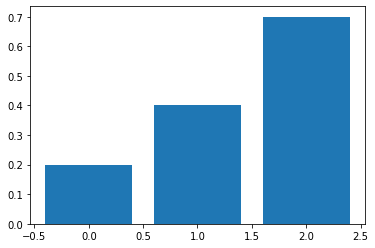

In [122]:
plt.bar(np.arange(3), torch.tensor(np.array([0.2, 0.4, 0.7])))

<BarContainer object of 3 artists>

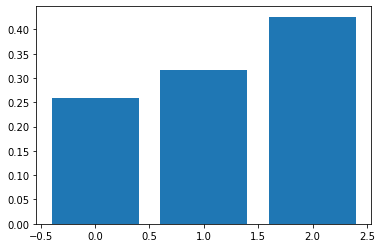

In [121]:
plt.bar(np.arange(3), torch.softmax(torch.tensor(np.array([0.2, 0.4, 0.7])), dim=-1))

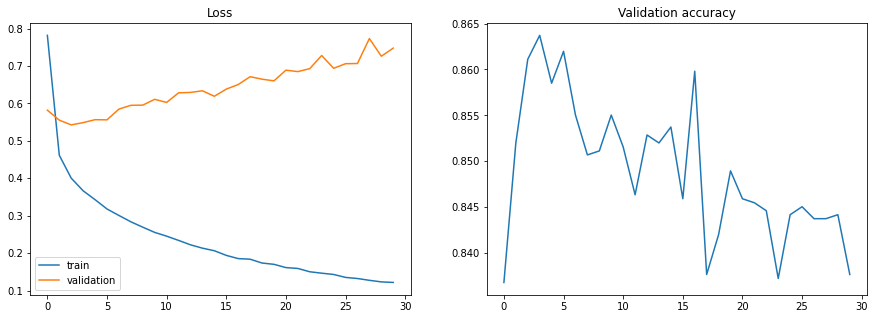

In [118]:
plot_train_process(train_loss, val_loss, val_accuracy)

## Real network

In [123]:
# create network again just in case
model = nn.Sequential(
    nn.Linear(784, 500),
    nn.ReLU(),
    nn.Linear(500, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [124]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, val_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 0.202s
	  training loss: 0.633287
	validation loss: 0.499345
	validation accuracy: 0.851
Epoch 2 of 30 took 0.189s
	  training loss: 0.305613
	validation loss: 0.488273
	validation accuracy: 0.861
Epoch 3 of 30 took 0.185s
	  training loss: 0.206981
	validation loss: 0.443356
	validation accuracy: 0.885
Epoch 4 of 30 took 0.194s
	  training loss: 0.173638
	validation loss: 0.512610
	validation accuracy: 0.870
Epoch 5 of 30 took 0.194s
	  training loss: 0.131250
	validation loss: 0.592555
	validation accuracy: 0.859
Epoch 6 of 30 took 0.192s
	  training loss: 0.089427
	validation loss: 0.621221
	validation accuracy: 0.863
Epoch 7 of 30 took 0.196s
	  training loss: 0.069743
	validation loss: 0.646907
	validation accuracy: 0.875
Epoch 8 of 30 took 0.189s
	  training loss: 0.039374
	validation loss: 0.731616
	validation accuracy: 0.868
Epoch 9 of 30 took 0.205s
	  training loss: 0.045555
	validation loss: 0.714356
	validation accuracy: 0.868
Epoch 10 of 30 took 0.195s
	

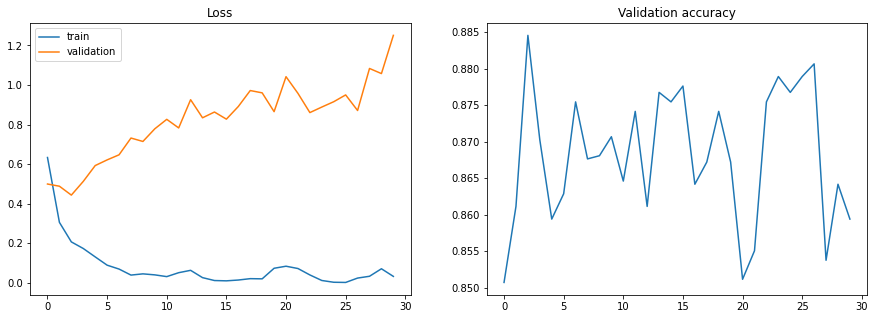

In [125]:
plot_train_process(train_loss, val_loss, val_accuracy)

## Your turn
Try to add some additional transformations (e.g. random crop, rotation etc.) and train your model!

Special activation function class example:

In [137]:
class NormalizedTanh(nn.Module):
    def __init__(self, arg_scale=1., out_scale=1.):
        super(self.__class__, self).__init__()
        self.arg_scale = arg_scale
        self.out_scale = out_scale
    
    def forward(self, x):
        return self.out_scale * torch.tanh(self.arg_scale * x)

In [141]:
n_tanh = NormalizedTanh(1.7, 0.8)

In [142]:
nn.Sequential(*[nn.Linear(784, 128), NormalizedTanh(1.7, 0.8)])

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): NormalizedTanh()
)

### Dropout try

### Batchnorm try

### 3. Save the model (model checkpointing)

Now we have trained a model! Obviously we do not want to retrain the model everytime we want to use it. Plus if you are training a super big model, you probably want to save checkpoint periodically so that you can always fall back to the last checkpoint in case something bad happened or you simply want to test models at different training iterations.

Model checkpointing is fairly simple in PyTorch. First, we define a helper function that can save a model to the disk

In [126]:
def save_checkpoint(checkpoint_path, model, optimizer):
    # state_dict: a Python dictionary object that:
    # - for a model, maps each layer to its parameter tensor;
    # - for an optimizer, contains info about the optimizer’s states and hyperparameters used.
    state = {
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

In [131]:
# create a brand new model
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Testing -- you should get a pretty poor performance since the model hasn't learned anything yet.

#### Define a training loop with model checkpointing

In [ ]:
def train_save(epoch, save_interval, log_interval=100):
    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            # different from before: saving model checkpoints
            if iteration % save_interval == 0 and iteration > 0:
                save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)
            iteration += 1
        test()
    
    # save the final model
    save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)

In [ ]:
train_save(5, save_interval=500, log_interval=100)

In [ ]:
# create a new model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# load from the final checkpoint
load_checkpoint('mnist-4690.pth', model, optimizer)
# should give you the final model accuracy
test()

```

```

```

```

```

```

```

```

```

```
### More about pytorch:
* Using torch on GPU and multi-GPU - [link](http://pytorch.org/docs/master/notes/cuda.html)
* More tutorials on pytorch - [link](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
* Pytorch examples - a repo that implements many cool DL models in pytorch - [link](https://github.com/pytorch/examples)
* Practical pytorch - a repo that implements some... other cool DL models... yes, in pytorch - [link](https://github.com/spro/practical-pytorch)
* And some more - [link](https://www.reddit.com/r/pytorch/comments/6z0yeo/pytorch_and_pytorch_tricks_for_kaggle/)